In [1]:
#This is the MOST basic linear classifiers.  
#It adjusts the weights based upon the error of each data point from the target per epoch 

import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        #size = w0 + a weight for your n_features of your input
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        #the underscore will ignore the actual index of range 
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                #update*xi is a vector
                self.w_[1:] += update * xi
                #our x0=1 and our bias unit is w_[0]=-theta
                self.w_[0] += update*1
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)


Now let's test out how well this percepton classifies the Iris cultivars: Setosa and Versicolor, based upon sepal and petal length. 

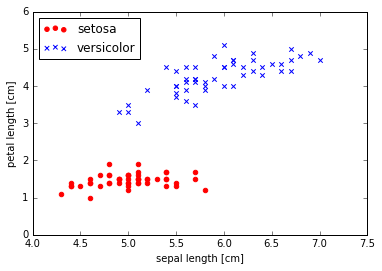

<function matplotlib.pyplot.show>

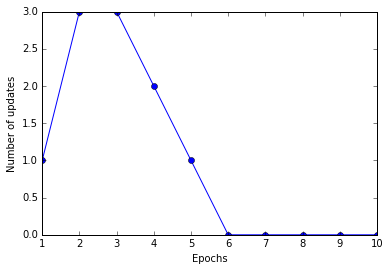

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor in first 100 data points.  These will be the targets for training data
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show



Let's see where our percepton sets the decision bondary between the two different cultivars. 

In [4]:
from matplotlib.colors import ListedColormap


#This function generates a 2x2 numerical grid of data features and calls the classifier to predict the class (positive or negative) depending on the feature coordinate
#The predicted classes "Z" is depicted in color on the contour plot

def plot_decision_regions(X, y, Labels,classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #While you need the grid from the contour plot, you need just x1 and x2 values for your neural network
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    #what enumerate does is associates a number with each unique instance of y
    
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=Labels[idx], 
                    edgecolor='black')



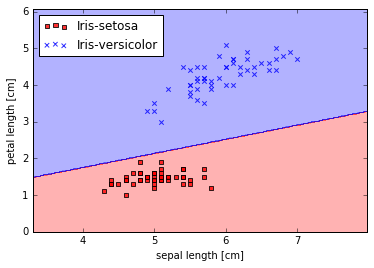

In [5]:
plot_decision_regions(X, y, df.iloc[0:100, 4].unique(),classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')


# plt.savefig('images/02_08.png', dpi=300)
plt.show()


In [8]:
#Here we improve upon our first linear classifier  
#This  adjusts the weights by minimizing a cost function, which is updated every epoch

import numpy as np


class Adaline(object):
    """Adaptive Perceptron classifier.  Finds weights by minizing cost function

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list of cost=sum(error^2)/2 in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        #size = w0 + a weight for your n_features of your input
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        #the underscore will ignore the actual index of range 
        for i in range(self.n_iter):
            input= self.net_input(X)
            output=input  #Can put in activation function here
            error = (y-output)
            self.w_[1:] +=self.eta*X.T.dot(error)
            self.w_[0] +=self.eta*error.sum()
            cost=(error**2).sum()/2
            self.cost_.append(cost)
            
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

   
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)


For unscaled data, the error increases when eta is too "large" and leads to overshooting.  The the first plot is with eta = 0.01 and the second eta = 0.0001

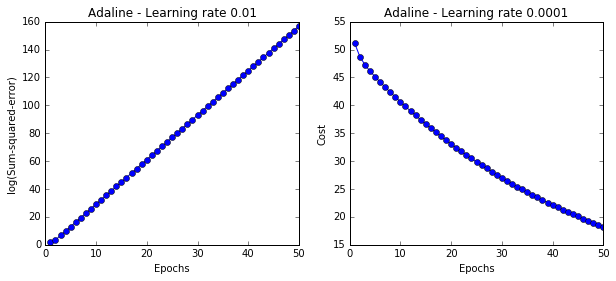

In [13]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = Adaline(n_iter=50, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = Adaline(n_iter=50, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Cost')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()


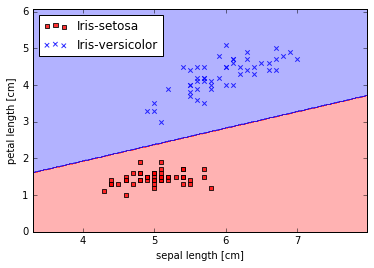

In [10]:
#In order to produce the same dividing lines as perceptron, need to do lots of iterations

plot_decision_regions(X, y, df.iloc[0:100, 4].unique(),classifier=ada2)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')


# plt.savefig('images/02_08.png', dpi=300)
plt.show()


We can achieve the same results by rescaling data and even using a larger eta!!


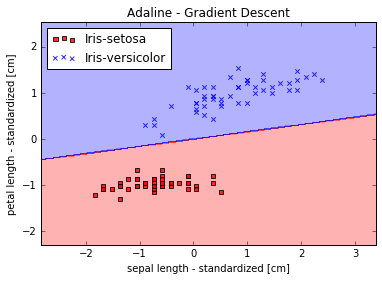

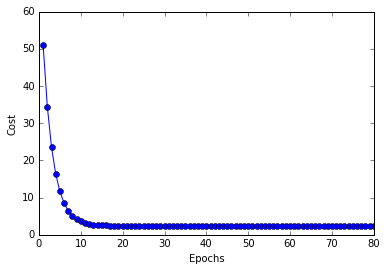

In [12]:

X_scaled =np.copy(X)

def rescaler(X):
    #rescales data by mean and standard deviation
    return (X-X.mean())/X.std()
    
    
X_scaled[:,0] = rescaler(X_scaled[:,0])    
X_scaled[:,1] = rescaler(X_scaled[:,1])    
    


ada1 = Adaline(n_iter=80, eta=0.01).fit(X_scaled, y)

plot_decision_regions(X_scaled, y, df.iloc[0:100, 4].unique(),classifier=ada1)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length - standardized [cm]')
plt.ylabel('petal length - standardized [cm]')
plt.legend(loc='upper left')


# plt.savefig('images/02_08.png', dpi=300)
plt.show()


plt.plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cost')


# plt.savefig('images/02_11.png', dpi=300)
plt.show()
    